# Finetune VGG16 - IF CONTINUING, NEED TO CHANGE TO THE VERSION WITH CLASSIFICATION REPORT


With 1000 x 400 melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'vgg16_normalized'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.vgg16(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.classifier[-1].parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Get the train set stats


In [14]:
import json

with open("../../../data/train_set_stats.json", "r") as f:
    stats = json.load(f)

mean = stats["mean"]
std = stats["std"]

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [0.21260474622249603, 0.07653550803661346, 0.18260346353054047]
Std: [0.2794255018234253, 0.1220870390534401, 0.1852213442325592]


Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for VGG16
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    # Normalize to the train set
    transforms.Normalize(mean=mean, std=std)
])

epochs = 25

C:\Users\profi\AppData\Local\Temp\ipykernel_24976\3561524770.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.84it/s, Loss=1.466273307800293, Elapsed=26.0020s, ETA=0.0000s]  


Epoch 1 completed in 103.7430s
Train Loss: 1.4833102074661695 - Train Accuracy: 39.66215146649782
Validation Loss: 1.2825575749079385 - Validation Accuracy: 46.042634022794424

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.2843294143676758, Elapsed=26.0039s, ETA=0.0000s] 


Epoch 2 completed in 102.8513s
Train Loss: 1.3836012348274276 - Train Accuracy: 42.730829244024335
Validation Loss: 1.2836812512079874 - Validation Accuracy: 48.311523849725624

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.4461076259613037, Elapsed=25.8653s, ETA=0.0000s] 


Epoch 3 completed in 102.1685s
Train Loss: 1.3653779966982802 - Train Accuracy: 43.59014947649307
Validation Loss: 1.2285360272725423 - Validation Accuracy: 49.06078514140988

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.2476732730865479, Elapsed=25.7988s, ETA=0.0000s] 


Epoch 4 completed in 102.1958s
Train Loss: 1.3683238949389815 - Train Accuracy: 43.79367268944619
Validation Loss: 1.2127926842371624 - Validation Accuracy: 48.2271000422119

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.421819806098938, Elapsed=26.0092s, ETA=0.0000s]  


Epoch 5 completed in 102.5714s
Train Loss: 1.357050253821246 - Train Accuracy: 43.77105899911807
Validation Loss: 1.2321547301610312 - Validation Accuracy: 48.016040523427606

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.99it/s, Loss=1.3108975887298584, Elapsed=25.5299s, ETA=0.0000s] 


Epoch 6 completed in 101.9047s
Train Loss: 1.35396861823308 - Train Accuracy: 44.110264354039934
Validation Loss: 1.2094470914204916 - Validation Accuracy: 48.10046433094133

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.2699308395385742, Elapsed=25.9372s, ETA=0.0000s] 


Epoch 7 completed in 102.3763s
Train Loss: 1.356851229088844 - Train Accuracy: 44.467560661224304
Validation Loss: 1.2334302870432536 - Validation Accuracy: 48.69143098353736

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.85it/s, Loss=1.2910712957382202, Elapsed=26.0345s, ETA=0.0000s] 


Epoch 8 completed in 102.3961s
Train Loss: 1.351640713697224 - Train Accuracy: 44.44494697089618
Validation Loss: 1.2241584157943726 - Validation Accuracy: 46.74968341072183

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.95it/s, Loss=1.2268314361572266, Elapsed=26.1339s, ETA=0.0000s] 


Epoch 9 completed in 102.5358s
Train Loss: 1.3508035767974191 - Train Accuracy: 44.18941227018837
Validation Loss: 1.1961495351791382 - Validation Accuracy: 49.82059940903334

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.4351030588150024, Elapsed=25.9737s, ETA=0.0000s] 


Epoch 10 completed in 102.9991s
Train Loss: 1.3419212798851763 - Train Accuracy: 44.51731077994618
Validation Loss: 1.2147319881121317 - Validation Accuracy: 49.366821443647105

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.4135246276855469, Elapsed=25.7988s, ETA=0.0000s] 


Epoch 11 completed in 102.1410s
Train Loss: 1.3533331169558398 - Train Accuracy: 44.48112887542118
Validation Loss: 1.21566815217336 - Validation Accuracy: 50.01055297593921

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.3007476329803467, Elapsed=25.9256s, ETA=0.0000s] 


Epoch 12 completed in 102.1991s
Train Loss: 1.347377835326112 - Train Accuracy: 44.70952714773524
Validation Loss: 1.2180822650591532 - Validation Accuracy: 48.41705360911777

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.2161134481430054, Elapsed=25.8884s, ETA=0.0000s] 


Epoch 13 completed in 101.9483s
Train Loss: 1.353073257931395 - Train Accuracy: 44.31604893602587
Validation Loss: 1.1951171867052715 - Validation Accuracy: 47.425073870831575

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.91it/s, Loss=1.1429470777511597, Elapsed=25.9753s, ETA=0.0000s] 


Epoch 14 completed in 101.9792s
Train Loss: 1.3596876501347976 - Train Accuracy: 44.35675357861649
Validation Loss: 1.2174229009946187 - Validation Accuracy: 48.53313634444913

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.0463868379592896, Elapsed=25.9383s, ETA=0.0000s] 


Epoch 15 completed in 102.1778s
Train Loss: 1.3514778977529163 - Train Accuracy: 44.447208339929
Validation Loss: 1.193286649386088 - Validation Accuracy: 47.85774588433938

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.3316435813903809, Elapsed=25.9449s, ETA=0.0000s] 


Epoch 16 completed in 102.1588s
Train Loss: 1.3513040594282868 - Train Accuracy: 44.648470183849305
Validation Loss: 1.2221926752726238 - Validation Accuracy: 49.715069649641194

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.92it/s, Loss=1.1271040439605713, Elapsed=25.8216s, ETA=0.0000s] 


Epoch 17 completed in 102.0295s
Train Loss: 1.3457756769450413 - Train Accuracy: 44.61681101738993
Validation Loss: 1.1843233307202656 - Validation Accuracy: 48.427606585056985

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s, Loss=1.2781493663787842, Elapsed=26.0881s, ETA=0.0000s] 


Epoch 18 completed in 102.4575s
Train Loss: 1.3461525667609506 - Train Accuracy: 44.78867506388367
Validation Loss: 1.2223567986488342 - Validation Accuracy: 50.24271844660194

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.85it/s, Loss=1.5669611692428589, Elapsed=26.1088s, ETA=0.0000s] 


Epoch 19 completed in 102.5813s
Train Loss: 1.3467852936659246 - Train Accuracy: 44.63490196965243
Validation Loss: 1.2261083579063417 - Validation Accuracy: 50.87589700295483

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.88it/s, Loss=1.0766750574111938, Elapsed=25.9227s, ETA=0.0000s] 


Epoch 20 completed in 102.2171s
Train Loss: 1.3421352106022697 - Train Accuracy: 44.84973202776961
Validation Loss: 1.173780304590861 - Validation Accuracy: 47.99493457154917

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.1456984281539917, Elapsed=25.7780s, ETA=0.0000s] 


Epoch 21 completed in 102.4265s
Train Loss: 1.3492085847551423 - Train Accuracy: 44.44042423283056
Validation Loss: 1.1886073017120362 - Validation Accuracy: 50.93921485859012

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.211137294769287, Elapsed=25.7540s, ETA=0.0000s]  


Epoch 22 completed in 102.1013s
Train Loss: 1.3403440813797747 - Train Accuracy: 44.75023179032586
Validation Loss: 1.2009297847747802 - Validation Accuracy: 49.5040101308569

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.86it/s, Loss=1.2389321327209473, Elapsed=26.0610s, ETA=0.0000s] 


Epoch 23 completed in 102.2817s
Train Loss: 1.3535157920997267 - Train Accuracy: 44.72987946903055
Validation Loss: 1.1860598778724671 - Validation Accuracy: 50.88644997889404

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.90it/s, Loss=1.304768681526184, Elapsed=26.1689s, ETA=0.0000s]  


Epoch 24 completed in 102.6377s
Train Loss: 1.3453594487526512 - Train Accuracy: 44.725356730964926
Validation Loss: 1.1835845788319905 - Validation Accuracy: 52.100042211903755

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:15<00:00,  4.93it/s, Loss=1.1409615278244019, Elapsed=25.7383s, ETA=0.0000s] 


Epoch 25 completed in 102.1702s
Train Loss: 1.3505143633467613 - Train Accuracy: 44.42459464960087
Validation Loss: 1.1967716439565024 - Validation Accuracy: 47.49894470240608



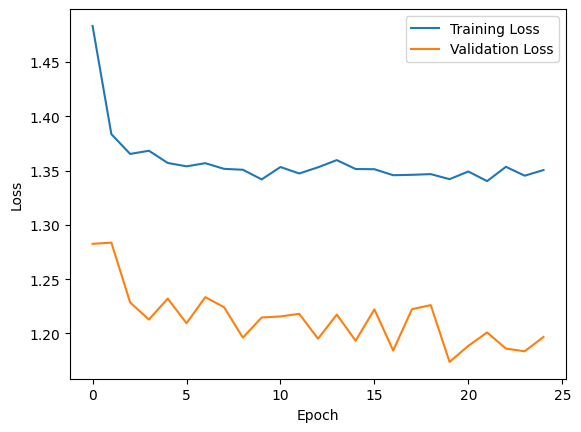

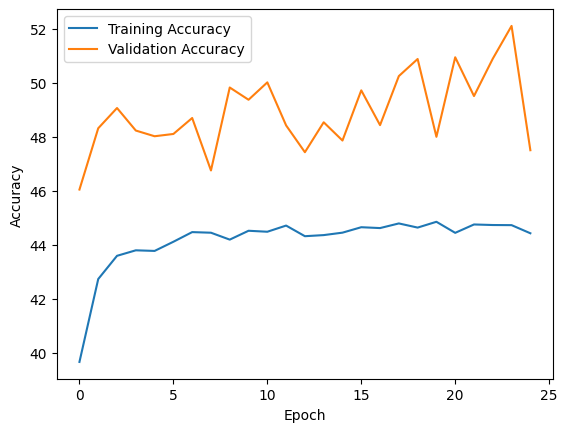

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_24976\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:26<00:00,  2.85it/s]



Test Results (Best Model):
Test Loss: 1.1696
Test Accuracy: 51.52%


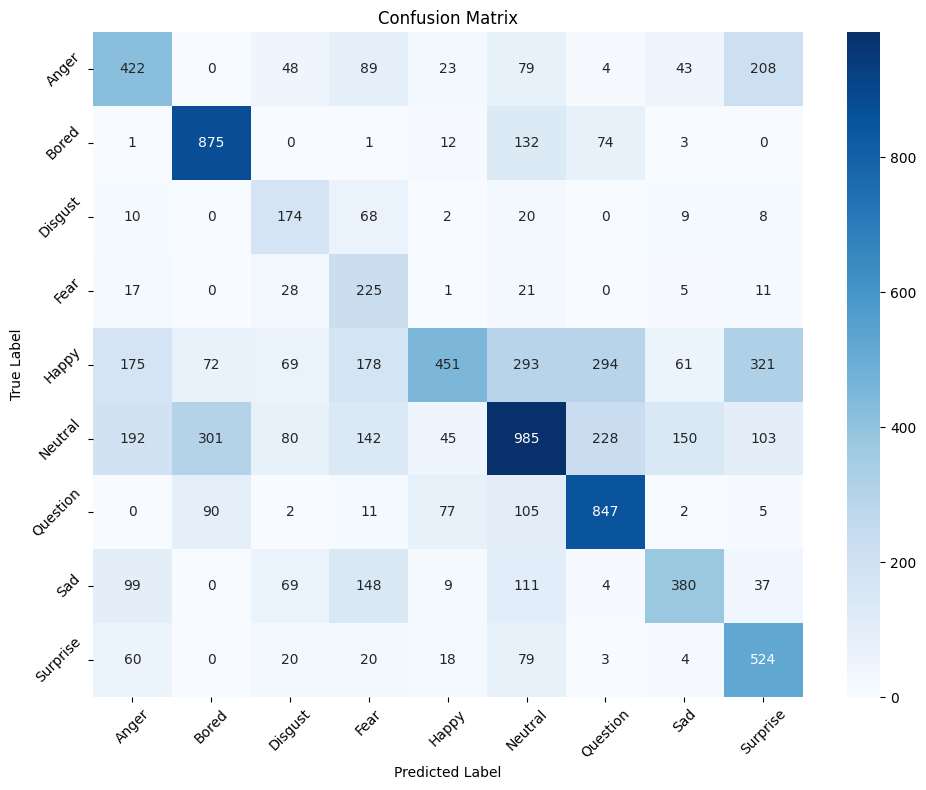

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)